In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics._ranking import _binary_clf_curve, precision_recall_curve
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import SpatialDropout1D, LSTM, Dense, Dropout, MaxPooling1D, Conv1D, GRU, TimeDistributed, Flatten
import keras.backend as K


In [2]:

num_of_drugs = 12


def masked_loss_function(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, -1), K.floatx())
    return K.binary_crossentropy(y_true * mask, y_pred * mask)


def masked_accuracy(y_true, y_pred):
    dtype = K.floatx()
    total = K.sum(K.cast(K.not_equal(y_true, -1), dtype))
    correct = K.sum(K.cast(K.equal(y_true, K.round(y_pred)), dtype))
    return correct / total




def specificity_recall_calculator(y_true, probas_pred, pos_label=None,
                                  sample_weight=None):
    fps, tps, thresholds = _binary_clf_curve(y_true, probas_pred,
                                             pos_label=pos_label,
                                             sample_weight=sample_weight)

    specificity = (fps[-1] - fps) / fps[-1]
    specificity[np.isnan(specificity)] = 0
    recall = tps / tps[-1]

    # stop when full recall attained
    # and reverse the outputs so recall is decreasing
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)
    return np.r_[specificity[sl], 1], np.r_[recall[sl], 0], thresholds[sl]

def SR_maker(y_test_tmp, y_pred_keras):
    specificity, recall, th = specificity_recall_calculator(y_test_tmp, y_pred_keras)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test_tmp, y_pred_keras)
    score = 0
    count = 0
    for i in range(0 ,len(recall)):
        if specificity[i] == 0.95:
            score += recall[i]
            count += count + 1

    if score != 0:
        return (score/count), auc(lr_recall, lr_precision)

    for i in range(0 ,len(recall)):
        if specificity[i] <= 0.952 and specificity[i] >= 0.945:
            score += recall[i]
            count += 1

    if score != 0:
        return (score/count), auc(lr_recall, lr_precision)

    for i in range(0, len(recall)):
        if specificity[i] <= 0.955 and specificity[i] >= 0.940:
            score += recall[i]
            count += 1
    if score != 0:
        return (score / count), auc(lr_recall, lr_precision)
    else:
        return 0, auc(lr_recall, lr_precision)

def ROC_ML(model, X_test, y_test, name, i, rf=False, xgb=False):
    if rf:
        ax = plt.gca()
        # print(len(X_test))
        # print(len(X_test[0]))
        # print(len(X_test[0][0]))
        # print(len(y_test))
        # print(len(y_test[0]))
        # print(len(y_test[0][0]))
        score = plot_roc_curve(model, X_test, y_test, ax=ax, alpha=0.8)
        plt.show()
        sr, pr = SR_maker(y_test, model.predict(X_test))
        return score.roc_auc, sr, pr
    else:
        if xgb:
            y_pred_keras_tmp = model.predict(X_test)
        else:
            y_pred_keras_tmp = model.decision_function(X_test)
        fpr_keras, tpr_keras, _ = roc_curve(y_test, y_pred_keras_tmp)
        auc_keras = auc(fpr_keras, tpr_keras)

        if i == 0 and name == "SVM":
            plt.clf()
        if i == 6 and name == "SVM":
            plt.clf()
        plt.figure(i)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label=name + str(i) + ' = {:.3f}'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve _ ' + name)
        plt.legend(loc='best')
        fig1 = plt.gcf()
        plt.show()
        plt.draw()
        # fig1.savefig('result/ROC_' + name + str(i) + '.png', dpi=100)

        sr, pr = SR_maker(y_test, model.predict(X_test))
        return auc_keras, sr, pr


def ROC_maker(y_test_tmp, y_pred_keras, name, clear=True, save=True):
    # print(y_test_tmp)
    fpr_keras, tpr_keras, _ = roc_curve(y_test_tmp, y_pred_keras)
    auc_keras = auc(fpr_keras, tpr_keras)

    if clear:
        plt.clf()
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve _ ' + name)
    plt.legend(loc='best')
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    # if save:
    #     fig1.savefig('result/ROC_' + name + '.png', dpi=100)
    return auc_keras
    # Zoom in view of the upper left corner.
    # plt.figure(2)
    # plt.xlim(0, 0.2)
    # plt.ylim(0.8, 1)
    # plt.plot([0, 1], [0, 1], 'k--')
    # plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
    # plt.xlabel('False positive rate')
    # plt.ylabel('True positive rate')
    # plt.title('ROC curve (zoomed in at top left)')
    # plt.legend(loc='best')
    # fig2 = plt.gcf()
    # plt.show()
    # plt.draw()
    # fig2.savefig('ROC_Zoom_' + name + '.png', dpi=100)

def ROC_Score(model, X_test, y_test, limited=False):
    global num_of_drugs

    y_pred_keras_tmp = model.predict(X_test)
    y_pred_keras = []
    y_test_tmp = []

    for i in range(0, num_of_drugs):
        y_test_tmp = y_test[:, i]
        y_pred_keras = y_pred_keras_tmp[:, i]
        i2 = 0
        while i2 < len(y_test_tmp):
            if y_test_tmp[i2] != 0 and y_test_tmp[i2] != 1:
                y_test_tmp = np.delete(y_test_tmp, i2)
                y_pred_keras = np.delete(y_pred_keras, i2)
            else:
                i2 = i2 + 1
    y_test_tmp = []
    y_pred_keras = []
    for i in range(0, num_of_drugs):
        y_test_tmp.extend(y_test[:, i])
        y_pred_keras.extend(y_pred_keras_tmp[:, i])
    i = 0
    while i < len(y_test_tmp):
        if y_test_tmp[i] != 0 and y_test_tmp[i] != 1:
            y_test_tmp = np.delete(y_test_tmp, i)
            y_pred_keras = np.delete(y_pred_keras, i)
        else:
            i = i + 1
    fpr_keras, tpr_keras, _ = roc_curve(y_test_tmp, y_pred_keras)
    # print("___")
    # print(fpr_keras)
    # print("___")
    # print(tpr_keras)
    # print("___")
    auc_keras = auc(fpr_keras, tpr_keras)
    # print(auc_keras)
    return auc_keras

def ROC(model, X_test, y_test, name, multi=False, limited=False, bccdc=False):
    y_pred_keras_tmp = model.predict(X_test)
    y_pred_keras = []
    y_test_tmp = []
    scores = []
    global num_of_drugs
    if limited:
        num_of_drugs = 7


    if bccdc:
        num_of_drugs = 5

        tmp_b = []
        for i in range(0, len(y_pred_keras_tmp)):
            tmp_b_b = [y_pred_keras_tmp[i][0], y_pred_keras_tmp[i][1], y_pred_keras_tmp[i][2], y_pred_keras_tmp[i][6],
                       y_pred_keras_tmp[i][8]]
            tmp_b.append(tmp_b_b)

        y_pred_keras_tmp = np.array(tmp_b)

    if multi == False:
        for i in range(0, len(y_pred_keras_tmp)):
            y_pred_keras.append(y_pred_keras_tmp[i][1])
            y_test_tmp.append(y_test[i][1])
        ROC_maker(y_test_tmp, y_pred_keras, name)
    else:
        for i in range(0, num_of_drugs):  # len(y_test[0])):
            y_test_tmp = y_test[:, i]
            y_pred_keras = y_pred_keras_tmp[:, i]
            # bug? cahnge i2 to i
            i2 = 0
            while i2 < len(y_test_tmp):
                if y_test_tmp[i2] != 0 and y_test_tmp[i2] != 1:
                    y_test_tmp = np.delete(y_test_tmp, i2)
                    y_pred_keras = np.delete(y_pred_keras, i2)
                else:
                    i2 = i2 + 1
            try:
                # print(len(y_test_tmp))
                # print(len(y_test_tmp[0]))
                # print(len(y_pred_keras))
                # print(len(y_pred_keras[0]))
                if i != 0:
                    if i < num_of_drugs - 1:
                        scores.append(ROC_maker(y_test_tmp, y_pred_keras, name + " _ " + str(i), False, False))
                    else:
                        scores.append(ROC_maker(y_test_tmp, y_pred_keras, name + " _ " + str(i), False, True))
                else:
                    scores.append(ROC_maker(y_test_tmp, y_pred_keras, name + " _ " + str(i), True, False))

            except():
                print("error on " + i + " " + y_test_tmp)
        y_test_tmp = []
        y_pred_keras = []
        for i in range(0, num_of_drugs):  # len(y_test[0])):
            y_test_tmp.extend(y_test[:, i])
            # print(y_test_tmp)
            y_pred_keras.extend(y_pred_keras_tmp[:, i])
        i = 0
        while i < len(y_test_tmp):
            if y_test_tmp[i] != 0 and y_test_tmp[i] != 1:
                y_test_tmp = np.delete(y_test_tmp, i)
                y_pred_keras = np.delete(y_pred_keras, i)
            else:
                i = i + 1
        ROC_maker(y_test_tmp, y_pred_keras, name + " _ All", True)
        # fpr_keras, tpr_keras, _ = roc_curve(y_test_tmp, y_pred_keras)
        # auc_keras = auc(fpr_keras, tpr_keras)
        # print(auc_keras)
        return scores


def PR(model, X_test, y_test, bccdc=False):
    y_pred_keras_tmp = model.predict(X_test)
    y_pred_keras = []
    y_test_tmp = []
    scores_sr = []
    scores_pr = []
    global num_of_drugs


    if bccdc:
        num_of_drugs = 5

        tmp_b = []
        for i in range(0, len(y_pred_keras_tmp)):
            tmp_b_b = [y_pred_keras_tmp[i][0], y_pred_keras_tmp[i][1], y_pred_keras_tmp[i][2], y_pred_keras_tmp[i][6],
                       y_pred_keras_tmp[i][8]]
            tmp_b.append(tmp_b_b)

        y_pred_keras_tmp = np.array(tmp_b)



    for i in range(0, num_of_drugs):  # len(y_test[0])):
        y_test_tmp = y_test[:, i]
        y_pred_keras = y_pred_keras_tmp[:, i]
        i2 = 0
        while i2 < len(y_test_tmp):
            if y_test_tmp[i2] != 0 and y_test_tmp[i2] != 1:
                y_test_tmp = np.delete(y_test_tmp, i2)
                y_pred_keras = np.delete(y_pred_keras, i2)
            else:
                i2 = i2 + 1
        try:
            if i != 0:
                if i < num_of_drugs - 1:
                    sr, pr = SR_maker(y_test_tmp, y_pred_keras)
                    scores_sr.append(sr)
                    scores_pr.append(pr)
                else:
                    sr, pr = SR_maker(y_test_tmp, y_pred_keras)
                    scores_sr.append(sr)
                    scores_pr.append(pr)
            else:
                sr, pr = SR_maker(y_test_tmp, y_pred_keras)
                scores_sr.append(sr)
                scores_pr.append(pr)

        except():
            print("error on " + i + " " + y_test_tmp)
    # y_test_tmp = []
    # y_pred_keras = []
    # for i in range(0, num_of_drugs):  # len(y_test[0])):
    #     y_test_tmp.extend(y_test[:, i])
    #     # print(y_test_tmp)
    #     y_pred_keras.extend(y_pred_keras_tmp[:, i])
    # i = 0
    # while i < len(y_test_tmp):
    #     if y_test_tmp[i] != 0 and y_test_tmp[i] != 1:
    #         y_test_tmp = np.delete(y_test_tmp, i)
    #         y_pred_keras = np.delete(y_pred_keras, i)
    #     else:
    #         i = i + 1
    # SR_maker(y_test_tmp, y_pred_keras)
    return scores_sr, scores_pr



##############################################################################################################################################################################

def run_single_fold(model):
    X_train2 = np.array(X_train).astype(np.float)
    X_test2 = np.array(X_test).astype(np.float)
    X_val2 = np.array(X_val).astype(np.float)

    y_train2 = np.array(y_train).astype(np.float)
    y_test2 = np.array(y_test).astype(np.float)
    y_val2 = np.array(y_val).astype(np.float)

    model.compile(
        loss=masked_loss_function,
        optimizer='Adam',
        metrics=[masked_accuracy]
    )
    # Train the model with the train dataset.
    history = model.fit(
        X_train2,
        y_train2,
        epochs=epochs,
        batch_size=128,
        # shuffle=True,
        verbose=2,
        validation_data=(X_val2, y_val2)
    )

    # score = ROC_PR.ROC_Score(model, X_val2, y_val2)
    # score_for_each_drug = ROC_PR.ROC(model, X_test2, y_test2, ("LRCN" + "BO_delete"), True)


    y_p = model.predict(X_test2)
    i = 0
    while i < len(y_test2):
        if y_test2[i] != 0 and y_test2[i] != 1:
            y_test2 = np.delete(y_test2, i)
            y_p = np.delete(y_p, i)
        else:
            i = i + 1
    score = ROC_maker(y_test, y_p, "asd")
    print('area under ROC curve for val:', score)
    # print(score_for_each_drug)

    return score

def run_one_fold(model):


    X_train2 = np.array(X_train).astype(np.float)
    X_test2 = np.array(X_test).astype(np.float)
    X_val2 = np.array(X_val).astype(np.float)

    y_train2 = np.array(y_train).astype(np.float)
    y_test2 = np.array(y_test).astype(np.float)
    y_val2 = np.array(y_val).astype(np.float)

    model.compile(
        loss=masked_loss_function,
        optimizer='Adam',
        metrics=[masked_accuracy]
    )
    # Train the model with the train dataset.
    history = model.fit(
        X_train2,
        y_train2,
        epochs=epochs,
        batch_size=128,
        # shuffle=True,
        verbose=2,
        validation_data=(X_val2, y_val2)
    )

    # Evaluate the model with the eval dataset.
    # score = model.evaluate(X_test, y_test, steps=10, verbose=0)
    # print('Test loss:', score[0])
    # print('Test accuracy:', score[1])

    # Return the accuracy.
    # print(history.history['val_masked_accuracy'])
    score = ROC_Score(model, X_val2, y_val2)
    score_test = ROC_Score(model, X_test2, y_test2)
    score_for_each_drug = ROC(model, X_test2, y_test2, ("LRCN" + "BO_delete"), True)
    spec_recall, prec_recall = PR(model, X_test2, y_test2)

    print('area under ROC curve for val:', score)
    print('area under ROC curve for test:', score_test)
    print(score_for_each_drug)
    print("recall at 95 spec: ", spec_recall)
    print("precision recall: ", prec_recall)



    return score





def get_model(dropout2_rate=0.2, dense_1_neurons=64,
              dense_2_neurons=64, dense_3_neurons=64, dense_4_neurons=64, dense_5_neurons=64,
              filterCNN1=5, kernelCNN1=3, poolCNN1=3,
              filterCNN2=5, kernelCNN2=3, poolCNN2=3,
              filterCNN3=5, kernelCNN3=3, poolCNN3=3,
              filterCNN4=5, kernelCNN4=3, poolCNN4=3,
              filterCNN5=5, kernelCNN5=3, poolCNN5=3,
              LSTM1=128, LSTM2=64, LSTM3=64, LSTM4=64, LSTM5=64, i1=1, i2=2, i3=1):

    model = Sequential()
    model.add(Dropout(dropout2_rate))
    limited = False
    single = False

    for i in range(0, i1):
        if i == 0:
            # model.add(TimeDistributed(Conv1D(filters=filterCNN1, kernel_size=kernelCNN1, activation='relu', padding='same')))
            # model.add(TimeDistributed(MaxPooling1D(pool_size=poolCNN1, padding='same')))
            model.add(Conv1D(filters=filterCNN1, kernel_size=kernelCNN1, activation='relu', padding='same'))
            model.add(MaxPooling1D(pool_size=poolCNN1, padding='same'))
        elif i == 1:
            # model.add(TimeDistributed(Conv1D(filters=filterCNN2, kernel_size=kernelCNN2, activation='relu', padding='same')))
            # model.add(TimeDistributed(MaxPooling1D(pool_size=poolCNN2, padding='same')))
            model.add(Conv1D(filters=filterCNN2, kernel_size=kernelCNN2, activation='relu', padding='same'))
            model.add(MaxPooling1D(pool_size=poolCNN2, padding='same'))
        elif i == 2:
            model.add(Conv1D(filters=filterCNN3, kernel_size=kernelCNN3, activation='relu', padding='same'))
            model.add(MaxPooling1D(pool_size=poolCNN3, padding='same'))
        elif i == 3:
            # model.add(TimeDistributed(Conv1D(filters=filterCNN4, kernel_size=kernelCNN4, activation='relu', padding='same')))
            # model.add(TimeDistributed(MaxPooling1D(pool_size=poolCNN4, padding='same')))
            model.add(Conv1D(filters=filterCNN4, kernel_size=kernelCNN4, activation='relu', padding='same'))
            model.add(MaxPooling1D(pool_size=poolCNN4, padding='same'))
        elif i == 4:
            # model.add(TimeDistributed(Conv1D(filters=filterCNN5, kernel_size=kernelCNN5, activation='relu', padding='same')))
            # model.add(TimeDistributed(MaxPooling1D(pool_size=poolCNN5, padding='same')))
            model.add(Conv1D(filters=filterCNN5, kernel_size=kernelCNN5, activation='relu', padding='same'))
            model.add(MaxPooling1D(pool_size=poolCNN5, padding='same'))


    # model.add(TimeDistributed(Flatten()))

    if i2 == 0:
        model.add(Flatten())

    for i in range(0, i2):
        if i == i2 - 1:
            if i == 0:
                model.add(LSTM(LSTM1, return_sequences=False, recurrent_dropout=0.3))
                model.add(Dropout(dropout2_rate))
            elif i == 1:
                model.add(LSTM(LSTM2, return_sequences=False, recurrent_dropout=0.3))
                model.add(Dropout(dropout2_rate))
            elif i == 2:
                model.add(LSTM(LSTM3, return_sequences=False, recurrent_dropout=0.3))
                model.add(Dropout(dropout2_rate))
            elif i == 3:
                model.add(LSTM(LSTM4, return_sequences=False, recurrent_dropout=0.3))
                model.add(Dropout(dropout2_rate))
            elif i == 4:
                model.add(LSTM(LSTM5, return_sequences=False, recurrent_dropout=0.3))
                model.add(Dropout(dropout2_rate))
            break
        if i == 0:
            model.add(LSTM(LSTM1, return_sequences=True, recurrent_dropout=0.3))
            model.add(SpatialDropout1D(dropout2_rate))
        elif i == 1:
            model.add(LSTM(LSTM2, return_sequences=True, recurrent_dropout=0.3))
            model.add(SpatialDropout1D(dropout2_rate))
        elif i == 2:
            model.add(LSTM(LSTM3, return_sequences=True, recurrent_dropout=0.3))
            model.add(SpatialDropout1D(dropout2_rate))
        elif i == 3:
            model.add(LSTM(LSTM4, return_sequences=True, recurrent_dropout=0.3))
            model.add(SpatialDropout1D(dropout2_rate))
        elif i == 4:
            model.add(LSTM(LSTM5, return_sequences=False, recurrent_dropout=0.3))
            model.add(Dropout(dropout2_rate))
    for i in range(0, i3):
        if i == 0:
            model.add(Dense(dense_1_neurons))
            model.add(Dropout(dropout2_rate))
        if i == 1:
            model.add(Dense(dense_2_neurons))
            model.add(Dropout(dropout2_rate))
        if i == 2:
            model.add(Dense(dense_3_neurons))
            model.add(Dropout(dropout2_rate))
        if i == 3:
            model.add(Dense(dense_4_neurons))
            model.add(Dropout(dropout2_rate))
        if i == 4:
            model.add(Dense(dense_5_neurons))
            model.add(Dropout(dropout2_rate))
    if limited :
        model.add(Dense(7, activation='sigmoid'))
    elif single:
        model.add(Dense(1, activation='sigmoid'))
    else:
        model.add(Dense(12, activation='sigmoid'))
    return model





def prepare_data(features, label):
    # TODO
    FrameSize = 200

    y = []
    for i in range(0, len(label)):
        label[i] = label[i].values.tolist()

    for j in range(0, len(label[0])):
        tmp = []
        for i in range(0, len(label)):
            if label[i][j][0] != 0.0 and label[i][j][0] != 1.0:
                tmp.extend([-1])
            else:
                tmp.extend(label[i][j])
        y.append(tmp)

    X = features.values.tolist()

    for i in range(0, len(X)):
        if len(X[i]) < ((len(X[i]) // FrameSize + 1) * FrameSize):
            for j in range(0, (((len(X[i]) // FrameSize + 1) * FrameSize) - len(X[i]))):
                X[i].append(0)
        X[i] = np.reshape(X[i], (FrameSize, len(X[i]) // FrameSize))

    X = np.array(X)
    y = np.array(y)
    return X, y, FrameSize



In [3]:
def process(num_of_files, nrow=0, gene=False, limited=False, gene_dataset=False, shuffle_index=False, random_data=False,
            shuffle_operon=False, shuffle_operon_locally=False, shuffle_operon_group=False, index_file=0):
    # ../../../../project/compbio-lab/Drug-resistance-TB/

    if gene_dataset:
        df_train = pd.read_csv('/local-scratch/parmis/LRCN-drug-resistance-master/Data/gene_data_19.csv', header=None, index_col=0)

    else:
        df_train = load_data.load_data(list(range(1, num_of_files)), 'Data/', nrow)

    # df_train = df_train[df_train.columns[df_train.sum() > 5]]

    df_label = pd.read_csv('/local-scratch/parmis/LRCN-drug-resistance-master/Data/AllLabels.csv', index_col=0)


    print('label set: {0}'.format(df_label.shape))

    df_train = df_train.merge(df_label, left_index=True, right_index=True)

    print('train set: {0}'.format(df_train.shape))
    labels = []

    labels_list = []

    dfStreptomycin = df_train[['streptomycin']]
    labels.append(dfStreptomycin)
    labels_list.append(df_train['streptomycin'])

    dfRifampicin = df_train[['rifampicin']]
    labels.append(dfRifampicin)
    labels_list.append(df_train['rifampicin'])

    dfPyrazinamide = df_train[['pyrazinamide']]
    labels.append(dfPyrazinamide)
    labels_list.append(df_train['pyrazinamide'])


    dfOfloxacin = df_train[['ofloxacin']]
    labels.append(dfOfloxacin)
    labels_list.append(df_train['ofloxacin'])


    dfMoxifloxacin = df_train[['moxifloxacin']]
    labels.append(dfMoxifloxacin)
    labels_list.append(df_train['moxifloxacin'])

    dfKanamycin = df_train[['kanamycin']]
    labels.append(dfKanamycin)
    labels_list.append(df_train['kanamycin'])


    dfIsoniazid = df_train[['isoniazid']]
    labels.append(dfIsoniazid)
    labels_list.append(df_train['isoniazid'])


    dfEthionamide = df_train[['ethionamide']]
    labels.append(dfEthionamide)
    labels_list.append(df_train['ethionamide'])

    dfEthambutol = df_train[['ethambutol']]
    labels.append(dfEthambutol)
    labels_list.append(df_train['ethambutol'])



    dfCiprofloxacin = df_train[['ciprofloxacin']]
    labels.append(dfCiprofloxacin)
    labels_list.append(df_train['ciprofloxacin'])

    dfCapreomycin = df_train[['capreomycin']]
    labels.append(dfCapreomycin)
    labels_list.append(df_train['capreomycin'])

    dfAmikacin = df_train[['amikacin']]
    labels.append(dfAmikacin)
    labels_list.append(df_train['amikacin'])

    df_train = df_train.drop(['streptomycin'], axis=1)
    df_train = df_train.drop(['rifampicin'], axis=1)
    df_train = df_train.drop(['pyrazinamide'], axis=1)
    df_train = df_train.drop(['ofloxacin'], axis=1)

    df_train = df_train.drop(['moxifloxacin'], axis=1)
    df_train = df_train.drop(['kanamycin'], axis=1)
    df_train = df_train.drop(['isoniazid'], axis=1)

    df_train = df_train.drop(['ethionamide'], axis=1)
    df_train = df_train.drop(['ethambutol'], axis=1)
    df_train = df_train.drop(['ciprofloxacin'], axis=1)
    df_train = df_train.drop(['capreomycin'], axis=1)
    df_train = df_train.drop(['amikacin'], axis=1)
    # print(dfStreptomycin.head(10))

    return df_train, labels


In [4]:
def load_data_gene_dataset(path):
    dt = pd.read_csv(path + 'gene_data.csv', header=None)
    dt.set_index(dt.columns[0], inplace=True, drop=True)
    return dt


In [5]:
import pandas as pd
df_train, labels = process(38, gene_dataset=True)
X, y, FrameSize = prepare_data(df_train, labels)
earlyStopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', min_delta=0.1, verbose=1, patience=80)



label set: (22376, 12)
train set: (7845, 3979)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1, shuffle=True)

In [7]:
model = get_model(dropout2_rate=0.2, dense_1_neurons=64,
              dense_2_neurons=64, dense_3_neurons=64, dense_4_neurons=64, dense_5_neurons=64,
              filterCNN1=5, kernelCNN1=3, poolCNN1=3,
              filterCNN2=5, kernelCNN2=3, poolCNN2=3,
              filterCNN3=5, kernelCNN3=3, poolCNN3=3,
              filterCNN4=5, kernelCNN4=3, poolCNN4=3,
              filterCNN5=5, kernelCNN5=3, poolCNN5=3,
              LSTM1=128, LSTM2=64, LSTM3=64, LSTM4=64, LSTM5=64, i1=1, i2=2, i3=1)


2021-11-28 16:05:16.813732: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-11-28 16:05:16.813755: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-11-28 16:05:16.814571: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
50/50 - 13s - loss: 0.2886 - masked_accuracy: 0.6554 - val_loss: 0.2744 - val_masked_accuracy: 0.6792 - 13s/epoch - 257ms/step
Epoch 2/10
50/50 - 7s - loss: 0.2799 - masked_accuracy: 0.6737 - val_loss: 0.2759 - val_masked_accuracy: 0.6792 - 7s/epoch - 144ms/step
Epoch 3/10
50/50 - 7s - loss: 0.2723 - masked_accuracy: 0.6860 - val_loss: 0.2601 - val_masked_accuracy: 0.7061 - 7s/epoch - 141ms/step
Epoch 4/10
50/50 - 7s - loss: 0.2663 - masked_accuracy: 0.7000 - val_loss: 0.2602 - val_masked_accuracy: 0.7061 - 7s/epoch - 147ms/step
Epoch 5/10
50/50 - 7s - loss: 0.2642 - masked_accuracy: 0.7007 - val_loss: 0.2598 - val_masked_accuracy: 0.7084 - 7s/epoch - 141ms/step
Epoch 6/10
50/50 - 7s - loss: 0.2624 - masked_accuracy: 0.7042 - val_loss: 0.2570 - val_masked_accuracy: 0.7123 - 7s/epoch - 141ms/step
Epoch 7/10
50/50 - 7s - loss: 0.2605 - masked_accuracy: 0.7073 - val_loss: 0.2577 - val_masked_accuracy: 0.7083 - 7s/epoch - 147ms/step
Epoch 8/10
50/50 - 7s - loss: 0.2574 - masked_

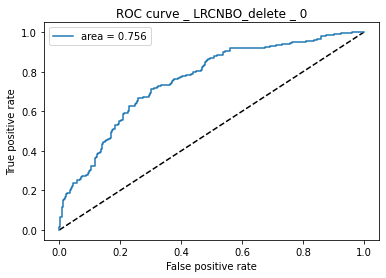

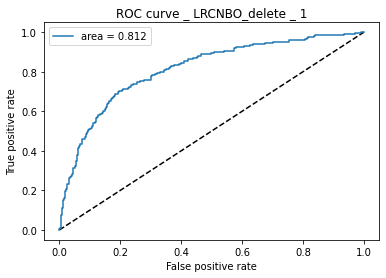

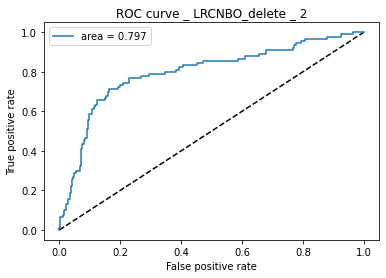

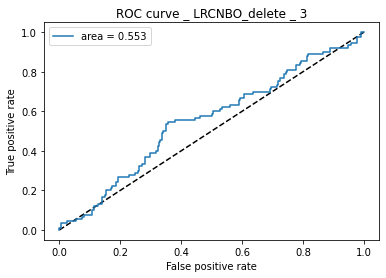

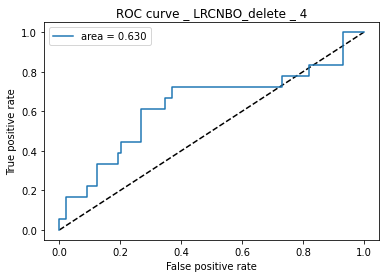

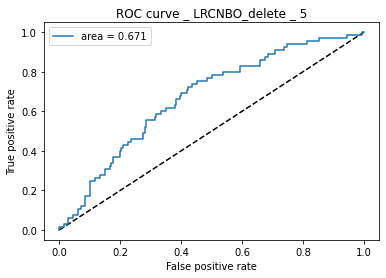

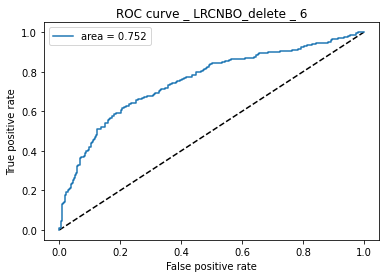

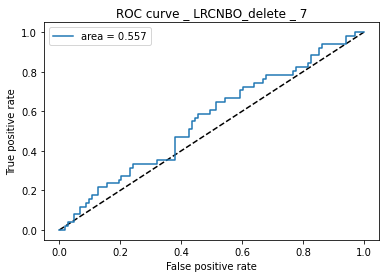

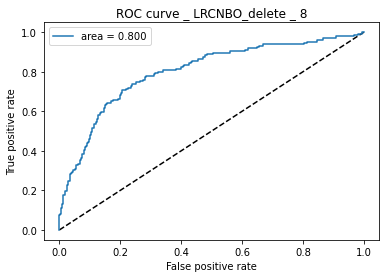

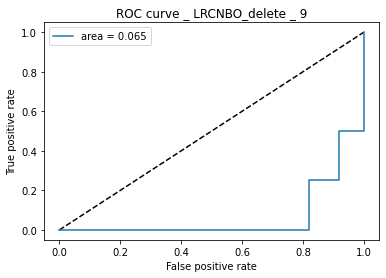

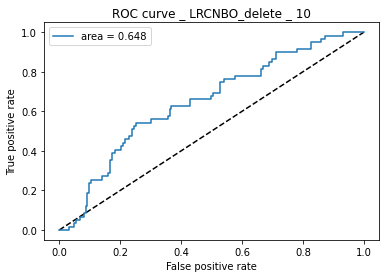

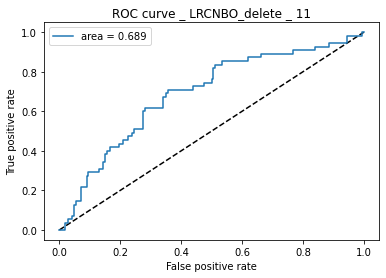

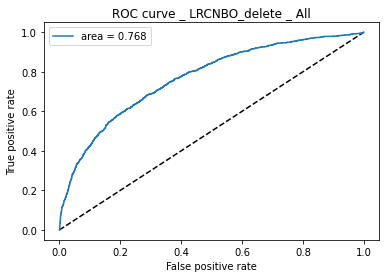

area under ROC curve for val: 0.7364038096601214
area under ROC curve for test: 0.7680952409045054
[0.7563402839327642, 0.812388030455716, 0.7968843843843844, 0.5526479750778817, 0.630461922596754, 0.6706677937447169, 0.7519400352733686, 0.5570150390253188, 0.80029871462193, 0.065, 0.6483310803784965, 0.6887445887445887]
recall at 95 spec:  [0.23868778280542985, 0.32670940170940177, 0.29259259259259257, 0.044444444444444446, 0.16666666666666666, 0.07692307692307693, 0.27295918367346933, 0.05882352941176471, 0.30936073059360725, 0, 0.025423728813559324, 0.13636363636363635]
precision recall:  [0.6925027357745392, 0.737996209229836, 0.556295438661833, 0.3397659039512815, 0.3161728633155484, 0.3830970845126542, 0.7363551915370737, 0.3662607825119413, 0.6002731031236147, 0.039061993240786894, 0.352355615356282, 0.37855188540248885]


0.7364038096601214

<Figure size 432x288 with 0 Axes>

In [8]:
epochs = 10
run_one_fold(model)

In [9]:
def run_k_fold(model):
    global X_train, X_test, y_train, y_test
    global X, y, check
    check = 0 
    if check == 0:
        check = 1
        X = np.append(X_train, X_test, axis=0)
        y = np.append(y_train, y_test, axis=0)
        X_train = 0
        X_test = 0
        y_train = 0
        y_test = 0

    cvscores = []
    scores_each_drug = []
    for i in range(0, 10):
        print("fold:" + str(i))
        length = int(len(X) / 10)
        if i == 0:
            X_train_tmp= X[length:]
            X_test_tmp = X[0:length]
            y_train_tmp = y[length:]
            y_test_tmp = y[0:length]
        elif i != 9:
            X_train_tmp = np.append(X[0:length * i], X[length * (i + 1):], axis=0)
            X_test_tmp = X[length * i:length * (i + 1)]
            y_train_tmp = np.append(y[0:length * i], y[length * (i + 1):], axis=0)
            y_test_tmp = y[length * i:length * (i + 1)]
        else:
            X_train_tmp = X[0:length * i]
            X_test_tmp = X[length * i:]
            y_train_tmp = y[0:length * i]
            y_test_tmp = y[length * i:]

        model.compile(
            loss=masked_loss_function,
            optimizer='Adam',
            metrics=[masked_accuracy]
        )

        # plot_model(model, to_file='model_plot.png', show_shapes=True)

        history = model.fit(
            X_train_tmp,
            y_train_tmp,
            epochs=epochs,
            batch_size=128,
            # shuffle=True,
            verbose=2,
            validation_data=(X_test_tmp, y_test_tmp)
        )

        score = ROC_PR.ROC_Score(model, X_train_tmp, y_train_tmp, limited=limited)
        print('area under ROC curve:', score)
        cvscores.append(score)
        scores_each_drug.append(ROC_PR.ROC(model, X_test_tmp, y_test_tmp, ("LRCN" + "BO_delete" + str(i)), True))
    print(np.mean(cvscores))
    if np.mean(cvscores) > 0.97:
        model.save()
    print(scores_each_drug)
    return np.mean(cvscores)


In [10]:
def model_lrcn_simple(FrameSize, X, X_train, X_test, y_train, y_test, epoch, earlyStopping, limited=False):
    print(X.shape)
    print(FrameSize)
    model = Sequential()
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=8, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=3, padding='same'))
    model.add(Conv1D(filters=4, kernel_size=6, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=4, padding='same'))
    
    model.add(LSTM(518, return_sequences=True, recurrent_dropout=0.3))
    model.add(SpatialDropout1D(0.2))
    
    model.add(LSTM(64, return_sequences=False, recurrent_dropout=0.3))
    model.add(Dropout(0.3))
    
    model.add(Dense(64))
    model.add(Dropout(0.1))
    model.add(Dense(518))
    model.add(Dropout(0.1))
    if limited:
        model.add(Dense(7, activation='sigmoid'))
    else:
        model.add(Dense(12, activation='sigmoid'))
    return model

(7845, 200, 20)
200
Epoch 1/200
50/50 - 15s - loss: 0.2808 - masked_accuracy: 0.6681 - val_loss: 0.2714 - val_masked_accuracy: 0.6792 - 15s/epoch - 292ms/step
Epoch 2/200
50/50 - 9s - loss: 0.2745 - masked_accuracy: 0.6787 - val_loss: 0.2631 - val_masked_accuracy: 0.7143 - 9s/epoch - 171ms/step
Epoch 3/200
50/50 - 9s - loss: 0.2620 - masked_accuracy: 0.7050 - val_loss: 0.2474 - val_masked_accuracy: 0.7333 - 9s/epoch - 171ms/step
Epoch 4/200
50/50 - 9s - loss: 0.2533 - masked_accuracy: 0.7192 - val_loss: 0.2435 - val_masked_accuracy: 0.7406 - 9s/epoch - 172ms/step
Epoch 5/200
50/50 - 9s - loss: 0.2466 - masked_accuracy: 0.7302 - val_loss: 0.2474 - val_masked_accuracy: 0.7442 - 9s/epoch - 181ms/step
Epoch 6/200
50/50 - 9s - loss: 0.2420 - masked_accuracy: 0.7405 - val_loss: 0.2299 - val_masked_accuracy: 0.7565 - 9s/epoch - 176ms/step
Epoch 7/200
50/50 - 9s - loss: 0.2351 - masked_accuracy: 0.7466 - val_loss: 0.2261 - val_masked_accuracy: 0.7653 - 9s/epoch - 172ms/step
Epoch 8/200
50/50 -

Epoch 61/200
50/50 - 8s - loss: 0.1927 - masked_accuracy: 0.8081 - val_loss: 0.1869 - val_masked_accuracy: 0.7979 - 8s/epoch - 170ms/step
Epoch 62/200
50/50 - 8s - loss: 0.1924 - masked_accuracy: 0.8085 - val_loss: 0.1851 - val_masked_accuracy: 0.8107 - 8s/epoch - 169ms/step
Epoch 63/200
50/50 - 9s - loss: 0.1925 - masked_accuracy: 0.8065 - val_loss: 0.1805 - val_masked_accuracy: 0.8125 - 9s/epoch - 172ms/step
Epoch 64/200
50/50 - 8s - loss: 0.1922 - masked_accuracy: 0.8077 - val_loss: 0.1833 - val_masked_accuracy: 0.8097 - 8s/epoch - 170ms/step
Epoch 65/200
50/50 - 8s - loss: 0.1934 - masked_accuracy: 0.8053 - val_loss: 0.1830 - val_masked_accuracy: 0.8151 - 8s/epoch - 169ms/step
Epoch 66/200
50/50 - 8s - loss: 0.1893 - masked_accuracy: 0.8102 - val_loss: 0.1770 - val_masked_accuracy: 0.8218 - 8s/epoch - 169ms/step
Epoch 67/200
50/50 - 8s - loss: 0.1932 - masked_accuracy: 0.8038 - val_loss: 0.1804 - val_masked_accuracy: 0.8162 - 8s/epoch - 169ms/step
Epoch 68/200
50/50 - 8s - loss: 0.

Epoch 121/200
50/50 - 8s - loss: 0.1784 - masked_accuracy: 0.8242 - val_loss: 0.1717 - val_masked_accuracy: 0.8225 - 8s/epoch - 170ms/step
Epoch 122/200
50/50 - 9s - loss: 0.1823 - masked_accuracy: 0.8188 - val_loss: 0.1692 - val_masked_accuracy: 0.8323 - 9s/epoch - 171ms/step
Epoch 123/200
50/50 - 8s - loss: 0.1801 - masked_accuracy: 0.8231 - val_loss: 0.1656 - val_masked_accuracy: 0.8387 - 8s/epoch - 169ms/step
Epoch 124/200
50/50 - 9s - loss: 0.1800 - masked_accuracy: 0.8224 - val_loss: 0.1697 - val_masked_accuracy: 0.8304 - 9s/epoch - 176ms/step
Epoch 125/200
50/50 - 9s - loss: 0.1791 - masked_accuracy: 0.8228 - val_loss: 0.1672 - val_masked_accuracy: 0.8333 - 9s/epoch - 178ms/step
Epoch 126/200
50/50 - 9s - loss: 0.1805 - masked_accuracy: 0.8212 - val_loss: 0.1662 - val_masked_accuracy: 0.8311 - 9s/epoch - 177ms/step
Epoch 127/200
50/50 - 9s - loss: 0.1821 - masked_accuracy: 0.8196 - val_loss: 0.1661 - val_masked_accuracy: 0.8359 - 9s/epoch - 172ms/step
Epoch 128/200
50/50 - 9s - 

Epoch 180/200
50/50 - 8s - loss: 0.1736 - masked_accuracy: 0.8313 - val_loss: 0.1587 - val_masked_accuracy: 0.8476 - 8s/epoch - 169ms/step
Epoch 181/200
50/50 - 8s - loss: 0.1707 - masked_accuracy: 0.8328 - val_loss: 0.1576 - val_masked_accuracy: 0.8453 - 8s/epoch - 169ms/step
Epoch 182/200
50/50 - 8s - loss: 0.1717 - masked_accuracy: 0.8317 - val_loss: 0.1572 - val_masked_accuracy: 0.8468 - 8s/epoch - 170ms/step
Epoch 183/200
50/50 - 9s - loss: 0.1693 - masked_accuracy: 0.8363 - val_loss: 0.1590 - val_masked_accuracy: 0.8446 - 9s/epoch - 172ms/step
Epoch 184/200
50/50 - 8s - loss: 0.1694 - masked_accuracy: 0.8327 - val_loss: 0.1588 - val_masked_accuracy: 0.8451 - 8s/epoch - 169ms/step
Epoch 185/200
50/50 - 9s - loss: 0.1705 - masked_accuracy: 0.8332 - val_loss: 0.1580 - val_masked_accuracy: 0.8448 - 9s/epoch - 171ms/step
Epoch 186/200
50/50 - 8s - loss: 0.1740 - masked_accuracy: 0.8276 - val_loss: 0.1579 - val_masked_accuracy: 0.8480 - 8s/epoch - 169ms/step
Epoch 187/200
50/50 - 8s - 

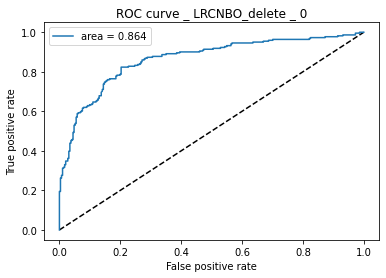

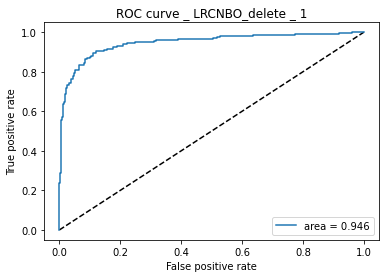

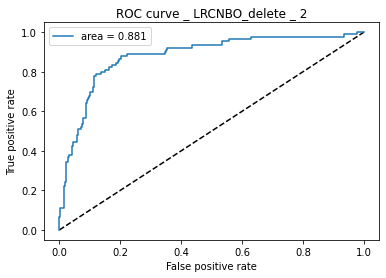

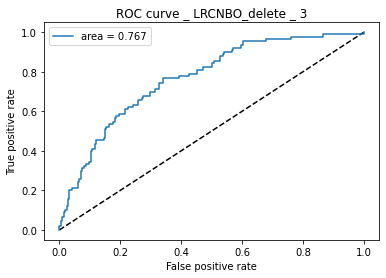

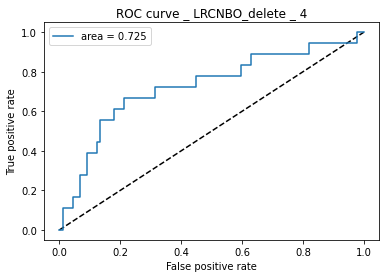

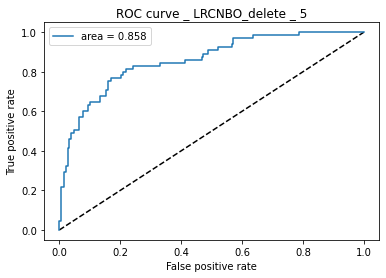

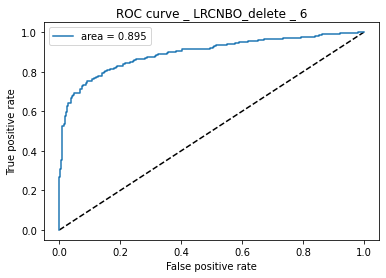

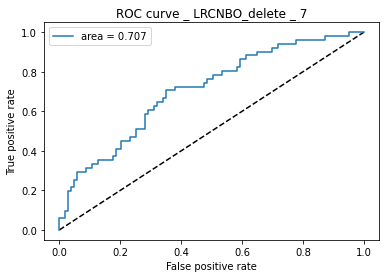

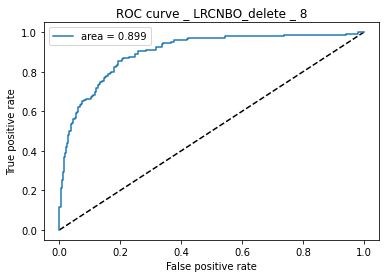

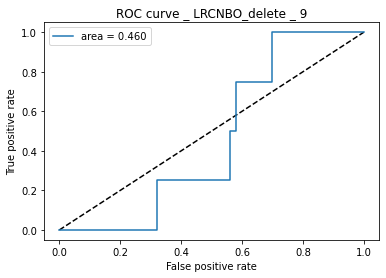

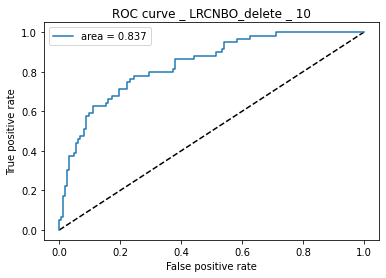

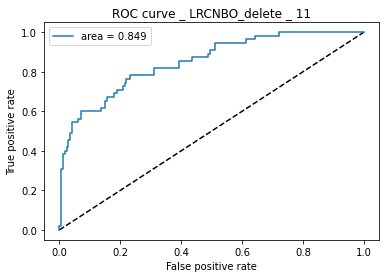

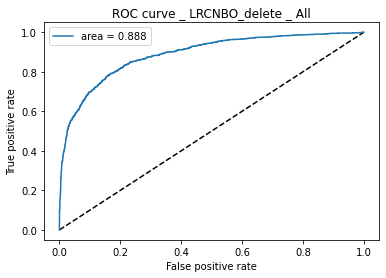

area under ROC curve for val: 0.9053686397702063
area under ROC curve for test: 0.8884847233447586
[0.8635925424888433, 0.9463735863845034, 0.8808183183183184, 0.7672377985462098, 0.7247191011235955, 0.8584953508030432, 0.8945868945868944, 0.7066438225775746, 0.8992215315913343, 0.46, 0.8365394613704897, 0.8491341991341992]
recall at 95 spec:  [0.5319004524886878, 0.7953648915187377, 0.4444444444444444, 0.2111111111111111, 0.16666666666666666, 0.5025641025641026, 0.6895604395604397, 0.2352941176470588, 0.569634703196347, 0, 0.3813559322033898, 0.5454545454545454]
precision recall:  [0.8491185399616477, 0.9361321024399712, 0.7020846984844601, 0.5614489147705252, 0.3466803945967163, 0.7151909081461485, 0.9078158538230592, 0.5546500173562793, 0.7664232849201066, 0.062468819339566786, 0.6580554125526935, 0.6941482005563171]


0.9053686397702063

<Figure size 432x288 with 0 Axes>

In [12]:
LRCN = model_lrcn_simple(FrameSize, X, X_train, X_test, y_train, y_test, epochs, earlyStopping,limited=False)
epochs = 200
run_one_fold(LRCN)